In [286]:
def benchmark(models,model_name,X_train,y_train,cv):
    
    measures = pd.DataFrame()
    AUC_test = []
    AUC_train = []
    Score_test = []
    Score_train =[]

    for model,name in zip(models,model_name): 
        AUC_v = cross_validate(model, X_train, y_train, scoring='roc_auc', cv=cv,return_train_score=True)
        AUC_test=AUC_v["test_score"].mean()
        AUC_train=AUC_v["train_score"].mean()
        Score_v = cross_validate(model, X_train, y_train, scoring='f1', cv=cv,return_train_score=True)
        Score_test=Score_v["test_score"].mean()
        Score_train=Score_v["train_score"].mean()
        measures[name] = [AUC_test, Score_test,AUC_train,Score_train]
        measures.index =['Test AUC Score', 'Test F-1 score','Train AUC Score', 'Train F-1 score']
    return measures

In [309]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import RepeatedStratifiedKFold,RandomizedSearchCV
from scipy.stats import loguniform
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import seaborn as sns

In [206]:
def model_comparison(models,X_train,y_train,cv):
    # Initiate a DataFrame for the averages and a list for all measures
    
    cv_accuracies = pd.DataFrame()
    AUC = []
    Accuracy = []

    for model in models:
        AUC_v = np.round(cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv,), 4)
        AUC=np.append(AUC,AUC_v)
        AUC_avg = round(AUC_v.mean(), 4)
        Accuracy_v = np.round(cross_val_score(model, X_train, y_train, scoring='f1', cv=cv), 4)
        Accuracy=np.append(Accuracy,Accuracy_v)
        Accuracy_avg = round(Accuracy_v.mean(), 4)
        cv_accuracies[str(model)] = [AUC_avg,Accuracy_avg]
    cv_accuracies.index = ["AUC Score",'Accuracy']
    return cv_accuracies, AUC

## Data exploratory and preprocessing

In [188]:
# Read train data
data = pd.read_csv('./Data/credit_default_train.csv')

In [189]:
data.head()

,cust_id,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,18895,70000.0,1.0,3.0,2.0,34.0,0.0,0.0,0.0,0.0,...,25559.0,26134.0,26715.0,1700.0,1500.0,2000.0,1000.0,1000.0,2000.0,0
1,25102,390000.0,2.0,2.0,2.0,26.0,2.0,2.0,2.0,0.0,...,140387.0,128112.0,115514.0,5000.0,3000.0,5000.0,4548.0,4100.0,3300.0,0
2,28867,60000.0,1.0,1.0,2.0,27.0,0.0,0.0,0.0,0.0,...,26038.0,28607.0,27997.0,1378.0,1406.0,3000.0,3000.0,0.0,923.0,1
3,1842,140000.0,2.0,2.0,1.0,55.0,0.0,0.0,0.0,0.0,...,72391.0,61298.0,62193.0,4200.0,2822.0,2336.0,2588.0,2250.0,2491.0,0
4,3371,50000.0,1.0,1.0,2.0,29.0,2.0,2.0,2.0,0.0,...,1047.0,0.0,0.0,3000.0,0.0,1000.0,0.0,0.0,0.0,1


In [190]:
data["AGE"] = pd.to_numeric(data["AGE"])

In [191]:
data.loc[data["SEX"]==1,"SEX"]="Male"
data.loc[data["SEX"]==2,"SEX"]="Female"
data.loc[data["EDUCATION"]==1,"EDUCATION"]="G_School"
data.loc[data["EDUCATION"]==2,"EDUCATION"]="Uni"
data.loc[data["EDUCATION"]==3,"EDUCATION"]="High_School"
data.loc[data["EDUCATION"]==4,"EDUCATION"]="Other_edu"
data.loc[data["EDUCATION"]==5,"EDUCATION"]="unknown"
data.loc[(data["EDUCATION"]==6) |(data["EDUCATION"]==0),"EDUCATION"]="unknown"
data.loc[data["MARRIAGE"]==1,"MARRIAGE"]="married"
data.loc[data["MARRIAGE"]==2,"MARRIAGE"]="single"
data.loc[(data["MARRIAGE"]==3) |(data["MARRIAGE"]==0),"MARRIAGE"]="Other_status"
data.loc[(data["AGE"]>=21) & (data["AGE"]<=39),"AGE_Cate"]="Young"
data.loc[(data["AGE"]>=40) & (data["AGE"]<=59),"AGE_Cate"]="Adult"
data.loc[data["AGE"]>=60,"AGE_Cate"]="Old"

In [192]:
sex_dummy = pd.get_dummies(data["SEX"],drop_first=True)
education_dummy = pd.get_dummies(data["EDUCATION"],drop_first=True)
mariage_dummy = pd.get_dummies(data["MARRIAGE"],drop_first=True)
age_dummy = pd.get_dummies(data["AGE_Cate"],drop_first=True)

In [193]:
data = pd.concat([data,sex_dummy,education_dummy,mariage_dummy,age_dummy], axis=1)

In [194]:
data.head()

,cust_id,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,AGE_Cate,Male,High_School,Other_edu,Uni,unknown,married,single,Old,Young
0,18895,70000.0,Male,High_School,single,34.0,0.0,0.0,0.0,0.0,...,Young,1,1,0,0,0,0,1,0,1
1,25102,390000.0,Female,Uni,single,26.0,2.0,2.0,2.0,0.0,...,Young,0,0,0,1,0,0,1,0,1
2,28867,60000.0,Male,G_School,single,27.0,0.0,0.0,0.0,0.0,...,Young,1,0,0,0,0,0,1,0,1
3,1842,140000.0,Female,Uni,married,55.0,0.0,0.0,0.0,0.0,...,Adult,0,0,0,1,0,1,0,0,0
4,3371,50000.0,Male,G_School,single,29.0,2.0,2.0,2.0,0.0,...,Young,1,0,0,0,0,0,1,0,1


In [195]:
data.columns

Index(['cust_id', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month', 'AGE_Cate', 'Male', 'High_School',
       'Other_edu', 'Uni', 'unknown', 'married', 'single', 'Old', 'Young'],
      dtype='object')

<AxesSubplot:>

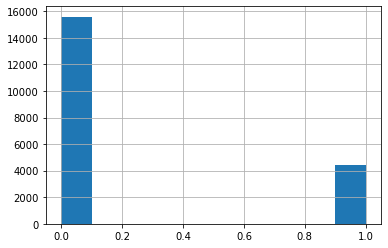

In [196]:
data["default.payment.next.month"].hist()

In [197]:
data["default.payment.next.month"].value_counts(normalize=True)

0    0.7793
1    0.2207
Name: default.payment.next.month, dtype: float64

In [198]:
data['Bill_Total']= data[list(data.filter(regex='BILL_'))].mean(axis=1)
data['Pay_AMT_Total']= data[list(data.filter(regex='PAY_AMT'))].mean(axis=1)

In [199]:
data.columns

Index(['cust_id', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month', 'AGE_Cate', 'Male', 'High_School',
       'Other_edu', 'Uni', 'unknown', 'married', 'single', 'Old', 'Young',
       'Bill_Total', 'Pay_AMT_Total'],
      dtype='object')

In [200]:
data= data.drop(columns=['cust_id',"SEX","EDUCATION","MARRIAGE","AGE",'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',"AGE_Cate"],)

In [201]:
data= data.dropna().reset_index()

In [202]:
X= pd.DataFrame(data.loc[:,['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'Male', 'High_School', 'Other_edu', 'Uni',
       'unknown', 'married', 'single', 'Old', 'Young', 'Bill_Total',
       'Pay_AMT_Total']])
Y = data.loc[:,'default.payment.next.month']

In [203]:
for column in X.columns:
    feature = np.array(X[column]).reshape(-1,1)
    scaler = MinMaxScaler()
    scaler.fit(feature)
    feature_scaled = scaler.transform(feature)
    X[column]= pd.DataFrame(feature_scaled.reshape(1,-1)[0])

## Feature selection using **F-value**

In [204]:
# feature selection 
fs = SelectKBest(score_func=f_classif, k=15)
fs.fit_transform(X, Y)
idx = fs.get_support(indices=True)

In [205]:
X = X.iloc[:,idx]

In [308]:
X

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,Male,High_School,Other_edu,Uni,unknown,married,single,Pay_AMT_Total
0,0.060606,0.2,0.2,0.2,0.2,0.2,0.2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.003976
1,0.383838,0.4,0.4,0.4,0.2,0.2,0.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.010781
2,0.050505,0.2,0.2,0.2,0.2,0.2,0.4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.004195
3,0.131313,0.2,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.007211
4,0.040404,0.4,0.4,0.4,0.2,0.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18615,0.494949,0.3,0.0,0.1,0.2,0.2,0.2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.082997
18616,0.020202,0.2,0.2,0.2,0.2,0.2,0.2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.005192
18617,0.010101,0.3,0.4,0.6,0.5,0.4,0.4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.001080
18618,0.232323,0.2,0.2,0.2,0.2,0.2,0.2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.070039


In [207]:
# Create the models to be tested
LR = LogisticRegression()
LDA_m = LDA()
KNN = KNeighborsClassifier()
DT = DecisionTreeClassifier()
SVM = LinearSVC()

# Put the models in a list to be used for Cross-Validation
models = [LR, LDA_m, KNN,DT,SVM]

# Run the Cross-Validation comparison with the models used in this analysis
comparison, AUC = model_comparison(models, X,Y, 20)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

In [208]:
comparison.columns  = ['Logistic Regression', 'LDA', 'KNN','Decision Tree',"SVM"]
comparison

,Logistic Regression,LDA,KNN,Decision Tree,SVM
AUC Score,0.7124,0.7111,0.6958,0.6081,0.7129
Accuracy,0.8073,0.8096,0.7917,0.7221,0.7966


In [530]:
AUC_comp = pd.DataFrame(np.reshape(AUC, (5,20)), index=comparison.columns, columns=['1st Fold', '2nd Fold', '3rd Fold', 
                                                         '4th Fold','5th Fold', '6th Fold', '7th Fold', 
                                                         '8th Fold', '9th Fold', 
                                                         '10th Fold','11st Fold', '12nd Fold', '13rd Fold', 
                                                         '14th Fold','15th Fold', '16th Fold', '17th Fold', 
                                                         '18th Fold', '19th Fold', 
                                                         '20th Fold'])

In [531]:
AUC_comp

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold,6th Fold,7th Fold,8th Fold,9th Fold,10th Fold,11st Fold,12nd Fold,13rd Fold,14th Fold,15th Fold,16th Fold,17th Fold,18th Fold,19th Fold,20th Fold
Logistic Regression,0.7118,0.6969,0.6972,0.7141,0.7030,0.7763,0.6873,0.6836,0.7047,0.7229,0.7090,0.6947,0.7333,0.6927,0.6967,0.6845,0.6986,0.6985,0.7186,0.6852
LDA,0.7116,0.6949,0.7044,0.7143,0.7083,0.7874,0.6881,0.6828,0.7053,0.7228,0.7088,0.6986,0.7367,0.6966,0.6985,0.6864,0.6969,0.6978,0.7236,0.6847
KNN,0.6876,0.6769,0.6626,0.7131,0.7303,0.7499,0.6851,0.6582,0.6870,0.7059,0.6883,0.7232,0.7002,0.6925,0.6718,0.6612,0.6584,0.6859,0.7410,0.6629
Decision Tree,0.6351,0.6461,0.6275,0.6379,0.6392,0.6482,0.5924,0.5931,0.6092,0.6078,0.5912,0.5865,0.6224,0.6180,0.6017,0.5874,0.6044,0.6172,0.6307,0.6208
SVM,0.7149,0.6967,0.7097,0.7178,0.7115,0.7915,0.6894,0.6831,0.7076,0.7235,0.7058,0.7013,0.7386,0.6979,0.6972,0.6855,0.6993,0.6994,0.7229,0.6877


## Over Sampling

In [209]:
# define pipeline
over = SMOTE(sampling_strategy=0.6)
X_resampled,y_resampled = over.fit_resample(X,Y)

In [210]:
y_resampled.value_counts()

0    14490
1     8694
Name: default.payment.next.month, dtype: int64

In [211]:
# Create the models to be tested
LR = LogisticRegression()
LDA_m = LDA()
KNN = KNeighborsClassifier()
DT = DecisionTreeClassifier()
SVM = LinearSVC()

# Put the models in a list to be used for Cross-Validation
models = [LR, LDA_m, KNN,DT,SVM]

# Run the Cross-Validation comparison with the models used in this analysis
comparison_resampled, AUC = model_comparison(models, X_resampled, y_resampled, 20)

In [212]:
comparison

,Logistic Regression,LDA,KNN,Decision Tree,SVM
AUC Score,0.7124,0.7111,0.6958,0.6081,0.7129
Accuracy,0.8073,0.8096,0.7917,0.7221,0.7966


In [213]:
comparison_resampled.columns  = ['Logistic Regression', 'LDA', 'KNN','Decision Tree',"SVM"]
comparison_resampled

,Logistic Regression,LDA,KNN,Decision Tree,SVM
AUC Score,0.7169,0.7164,0.8029,0.7084,0.7178
Accuracy,0.7337,0.7338,0.7469,0.7221,0.7340


## Logistic Regression 

In [214]:
# define cv
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=10, random_state=1)

In [215]:
# Define scoring matrices
scoring = {"AUC": "roc_auc", "F1":"f1"}

In [216]:
# Logistic regression model initiation
LR = LogisticRegression()

In [217]:
# define search space
space = dict()
space['solver'] = ['sag','saga', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

In [218]:
# define search
search = RandomizedSearchCV(LR, space, n_iter=60,scoring=scoring, n_jobs=-1, cv=cv, random_state=1,refit="F1",return_train_score=True)

In [219]:
# fit the model with cv and hyperparameter
LR_result = search.fit(X_resampled,y_resampled)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4000 fits failed out of a total of 12000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1000 fits failed with the following error:
Traceback (most recent call last):
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

--------------------------------------------------------------------------------
1600 fits failed with 

In [220]:
# summarize result
print('Best F1: %s' % LR_result.best_score_)
print('Best Hyperparameters: %s' % LR_result.best_params_)
print(LR_result.cv_results_["mean_test_AUC"][LR_result.best_index_])

Best F1: 0.5498484087392389
Best Hyperparameters: {'C': 0.0282759467303296, 'penalty': 'none', 'solver': 'sag'}
0.7199148293080748


In [221]:
LR_final = LogisticRegression(C=15.245533915454045, penalty='l1', solver='saga')
LR_final=LR_final.fit(X_resampled, y_resampled)

## Linear discriminant analysis

In [222]:
LDA_m = LDA()

In [223]:
# define search space
space = dict()
space['solver'] = ['svd','lsqr','eigen']
space['shrinkage']= np.arange(0, 1, 0.01)

In [224]:
# define search
search = RandomizedSearchCV(LDA_m, space, n_iter=60,scoring=scoring, n_jobs=-1, cv=cv, random_state=1,refit="F1",return_train_score=True)

In [225]:
LDA_result = search.fit(X_resampled, y_resampled)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3800 fits failed out of a total of 12000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3800 fits failed with the following error:
Traceback (most recent call last):
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\discriminant_analysis.py", line 583, in fit
    raise NotImplementedError("shrinkage not supported")
NotImplementedError: shrinkage not supported

  warnings.warn(some_fits_failed_message, FitFailedWarning)
C:\tools\Anaconda3\envs\py\lib\

In [226]:
# summarize result
print('Best F1: %s' % LDA_result.best_score_)
print('Best Hyperparameters: %s' % LDA_result.best_params_)

Best F1: 0.5455166606499169
Best Hyperparameters: {'solver': 'lsqr', 'shrinkage': 0.01}


In [227]:
LDA_final = LDA(solver='lsqr',shrinkage=0.01)
LDA_final=LDA_final.fit(X_resampled, y_resampled)

## K-nearest neighbors

In [228]:
KNN = KNeighborsClassifier()

In [229]:
# define search space
space = dict()
space['n_neighbors'] = [2,4,8,16,20,30,40,50,60]
space['p']=[1,2]

In [230]:
# define search
search = RandomizedSearchCV(KNN, space, n_iter=60,scoring=scoring, n_jobs=-1, cv=cv, random_state=1,refit="F1")

In [231]:
KNN_result = search.fit(X_resampled, y_resampled)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 18 is smaller than n_iter=60. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [232]:
# summarize result
print('Best F1: %s' % KNN_result.best_score_)
print('Best Hyperparameters: %s' % KNN_result.best_params_)
KNN_result.cv_results_["mean_test_AUC"][KNN_result.best_index_]

Best F1: 0.6292657437386413
Best Hyperparameters: {'p': 1, 'n_neighbors': 8}


0.8073745516419146

In [233]:
KNN_final = KNeighborsClassifier(n_neighbors=8,p=2)
KNN_final=KNN_final.fit(X_resampled, y_resampled)

## Decision Tree

In [234]:
DT = DecisionTreeClassifier()

In [235]:
# define search space
space = dict()
space['criterion'] = ["gini","entropy"]
space['splitter']=["best", "random"]
space['min_samples_leaf']=[1,2,3,4,5,6,7,8,9,10]
space['min_weight_fraction_leaf']=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
space['max_features']=["auto","log2","sqrt",None]
space['max_leaf_nodes']=[None,10,20,30,40,50,60,70,80,90]

In [236]:
# define search
search = RandomizedSearchCV(DT, space, n_iter=60,scoring=scoring, n_jobs=-1, cv=cv, random_state=1,refit="F1")

In [237]:
DT_result = search.fit(X_resampled, y_resampled)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5600 fits failed out of a total of 12000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5600 fits failed with the following error:
Traceback (most recent call last):
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\tree\_classes.py", line 304, in fit
    raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
ValueError: min_weight

In [238]:
# summarize result
print('Best F1 score: %s' % DT_result.best_score_)
print('Best Hyperparameters: %s' % DT_result.best_params_)
DT_result.cv_results_["mean_test_AUC"][DT_result.best_index_]

Best F1 score: 0.47043320279290923
Best Hyperparameters: {'splitter': 'best', 'min_weight_fraction_leaf': 0.1, 'min_samples_leaf': 9, 'max_leaf_nodes': None, 'max_features': 'auto', 'criterion': 'gini'}


0.6885679302844011

In [239]:
DT_final = DecisionTreeClassifier(splitter="best",min_weight_fraction_leaf=0.1,min_samples_leaf=9,max_leaf_nodes=None,max_features="auto",criterion="gini")
DT_final=DT_final.fit(X_resampled, y_resampled)

## SVM

In [240]:
SVM = LinearSVC()

In [241]:
# define search space
space = dict()
space['C'] = [0.001, 0.01, 10, 100, 1000]
space['penalty']=["l1", "l2"]
space['loss']=["hinge", "squared_hinge"]
space['class_weight']=[None,"balanced"]
space["max_iter"]=[2000,2500,3000]

In [242]:
# define search
search = RandomizedSearchCV(SVM, space, n_iter=60,scoring=scoring, n_jobs=-1, cv=cv, random_state=1,refit="F1")

In [243]:
SVM_result = search.fit(X_resampled, y_resampled)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5800 fits failed out of a total of 12000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3400 fits failed with the following error:
Traceback (most recent call last):
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_s

In [ ]:
# summarize result
print('Best F1: %s' % SVM_result.best_score_)
print('Best Hyperparameters: %s' % SVM_result.best_params_)
SVM_result.cv_results_["mean_test_AUC"][SVM_result.best_index_]

Best F1: 0.5742111278286377
Best Hyperparameters: {'penalty': 'l2', 'max_iter': 2000, 'loss': 'squared_hinge', 'class_weight': 'balanced', 'C': 10}


0.7221078174042441

In [244]:
SVM_final = LinearSVC(penalty="l2",loss='squared_hinge',class_weight='balanced',C=10,max_iter=2000)
SVM_final=SVM_final.fit(X_resampled, y_resampled)

## Benchmark

In [291]:
models = [LR_final,LDA_final,KNN_final,DT_final,SVM_final]
model_name = ['Logisitc Regression', 'LDA', "KNN",'Decision Tree',"SVM"]
measurement = benchmark(models,model_name,X_resampled,y_resampled,20)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase

In [292]:
measurement

,Logisitc Regression,LDA,KNN,Decision Tree,SVM
Test AUC Score,0.719959,0.712576,0.803573,0.681477,0.719362
Test F-1 score,0.550787,0.544861,0.628151,0.461304,0.592504
Train AUC Score,0.720755,0.713417,0.881195,0.686848,0.720220
Train F-1 score,0.550548,0.546177,0.702950,0.460256,0.593035


confusion matrix: KNN


<AxesSubplot:>

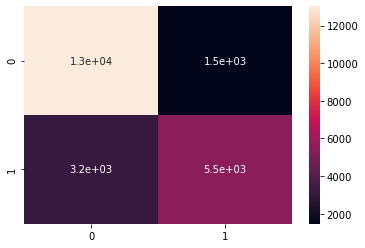

In [311]:
from sklearn.metrics import confusion_matrix
predictions = KNN_final.predict(X_resampled)
print("confusion matrix: KNN")
cf = confusion_matrix(y_resampled, predictions)
sns.heatmap(cf, annot=True)

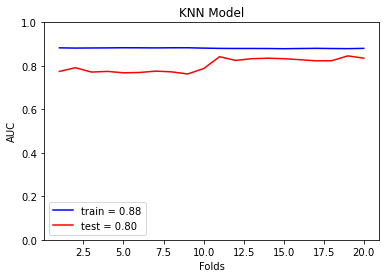

In [312]:
# How the AUC curve looks like when adding top vars

AUC_b= cross_validate(KNN_final, X_resampled,y_resampled, scoring='roc_auc', cv=20,return_train_score=True)
test_score = AUC_b["test_score"].reshape(20,1)
train_score = AUC_b["train_score"].reshape(20,1)
fold=[]
for i in range(0,20):
    fold = np.append(fold,i+1)
plt.title("KNN Model")
plt.plot(fold,train_score, color='blue')
plt.plot(fold,test_score, color='red')
plt.xlabel('Folds')
plt.ylabel('AUC')
plt.ylim([0, 1])
plt.legend(['train = 0.88', 'test = 0.80'])
plt.show()